# Preprocessing and Clustering

Herein is the code that follows the intial preprocessing and clustering pipeline as described by https://www.sc-best-practices.org/preamble.html

This pipeline is the result of much iteration and improvement to correctly capture all aspects of the data.


## Importing

In [ ]:
import subprocess

def pip_install(package):
    subprocess.run(["pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

pip_install("dynamo-release")
pip_install("scanpy")

In [ ]:
# importing key packages
from dynamo.preprocessing import Preprocessor
from sklearn.decomposition import PCA
import numpy as np
import anndata as ad
import scanpy as sc
from pickle import LONG1
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Full path to the .h5ad file
file_path = "/content/drive/My Drive/Colab Notebooks/NSC3001/anndata.h5ad"
adata = ad.read_h5ad(file_path)  # Without `backed="r"

In [ ]:
adata

AnnData object with n_obs × n_vars = 4840 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count'
    var: 'gene_id', 'gene_name', 'genome'

## Preprocessing

In [ ]:
# The final result was to use the dynamo preprocessor package, this was not the intiial intent however, its ease of use and strong results made it the best option
# this was after primarily investigating
# As the data was previously normalised and outlier cells were removed the qc pipeline is minimal herein
# the monocle recipe is recomended by dyn as the best recipe when no spliced data is present
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----? No layers exist in adata, skipp filtering by shared counts
|-----------> filtered out 39370 outlier genes
|-----? Transforming adata.X from int to float32 for normalization. If you want to disable this, set `transform_int_to_float` to False.
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [86.1027s]


In [ ]:
adata

AnnData object with n_obs × n_vars = 4840 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'gene_id', 'gene_name', 'genome', 'nCells', 'nCounts', 'pass_basic_filter', 'log_m', 'log_cv', 'score', 'frac', 'use_for_pca', 'ntr'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'

In [ ]:
sc.pp.neighbors(adata, n_pcs=26)
sc.tl.umap(adata)


In [ ]:
sc.tl.leiden(adata, resolution = 0.23)

### Labelling

Using exsisting sample data I add labels

In [ ]:
sample2label = {
    "sample_A1": "iPSC (WT)",
    "sample_B1": "iPSC (HET1)",
    "sample_A2": "LPM (WT)",
    "sample_B2": "LPM (HET1)",
    "sample_A3": "Arterial Pre-MACS (WT)",
    "sample_B3": "Arterial Pre-MACS (HET1)",
    "sample_A4": "Venous Pre-MACS (WT)",
    "sample_B4": "Venous Pre-MACS (HET1)",
    "sample_A5": "Arterial Pure (WT)",
    "sample_B5": "Arterial Pure (HET1)",
    "sample_B6": "Venous Pure (HET1)",
    "sample_C6": "Venous Pure (WT)"
}


In [ ]:
adata.obs['cell_identity'] = adata.obs['sample'].map(sample2label).astype('category')


In [ ]:

#sc.pl.umap(adata, color=['leiden', 'cell_identity'], legend_loc='on data')

In [ ]:
leiden_to_celltype = {
    '0': 'iPSC',         # High POU5F1, NANOG; from sample_A1
    '1': 'LPM',       # High POU5F1, NANOG; from sample_B1
    '2': 'Arterial Pre-MACS (HET1)',
    '3': 'Venous Pre-MACS',
    '4': 'Arterial Pre-MACS(WT)',
    '5': 'Arterial Pure (WT)',
    '6': 'Venous Pure (WT)',
    '7': 'Arterial Pure (HET1)',
    '8': 'Venous Pure (HET1)'
}

In [ ]:
adata.obs['cluster_identity'] = adata.obs['leiden'].map(leiden_to_celltype).astype('category')

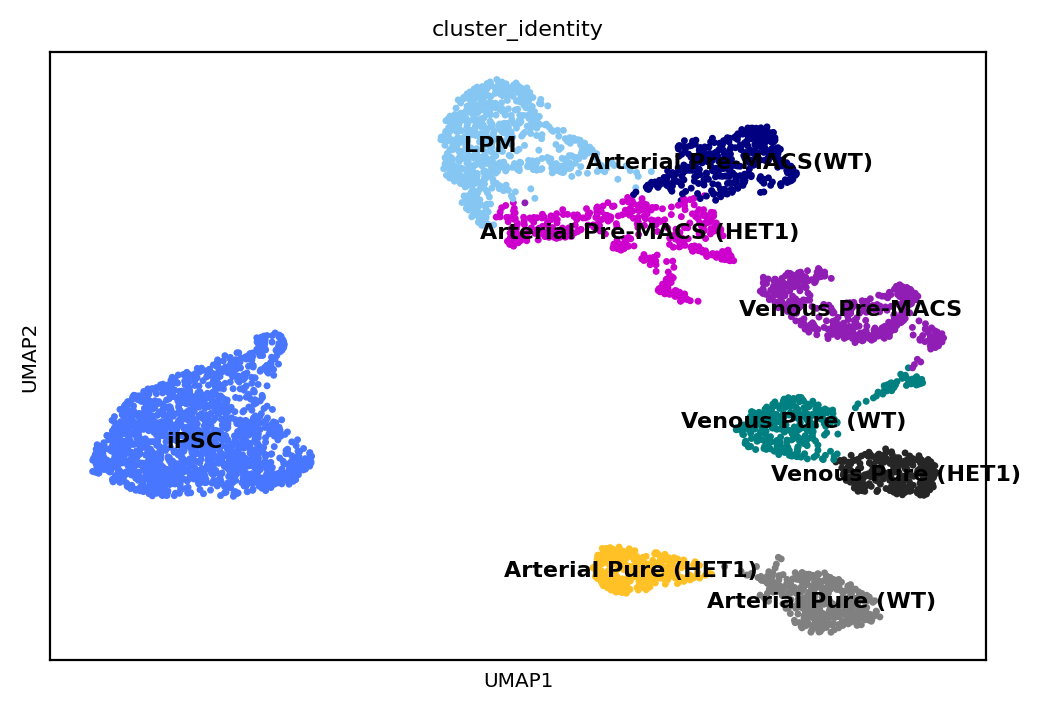

In [ ]:
sc.pl.umap(adata, color='cluster_identity', legend_loc='on data')

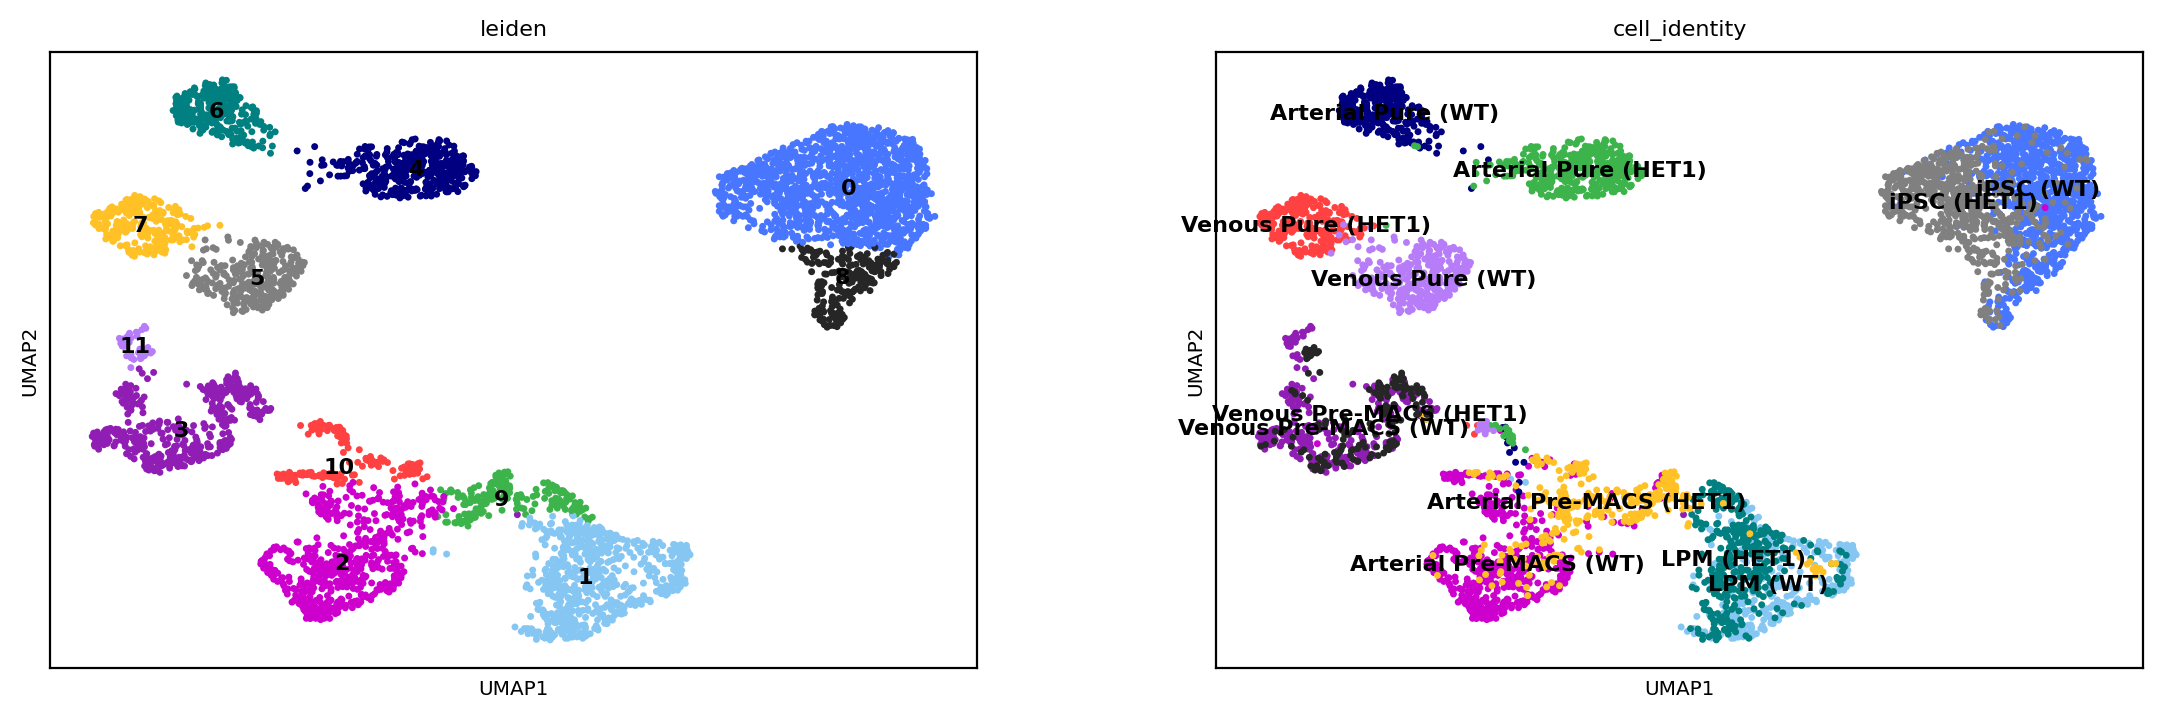

In [ ]:
# prompt: do dual plot for this and cell_identity: sc.pl.umap(adata, color='leiden', legend_loc='on data')

sc.pl.umap(adata, color=['leiden', 'cell_identity'], legend_loc='on data')


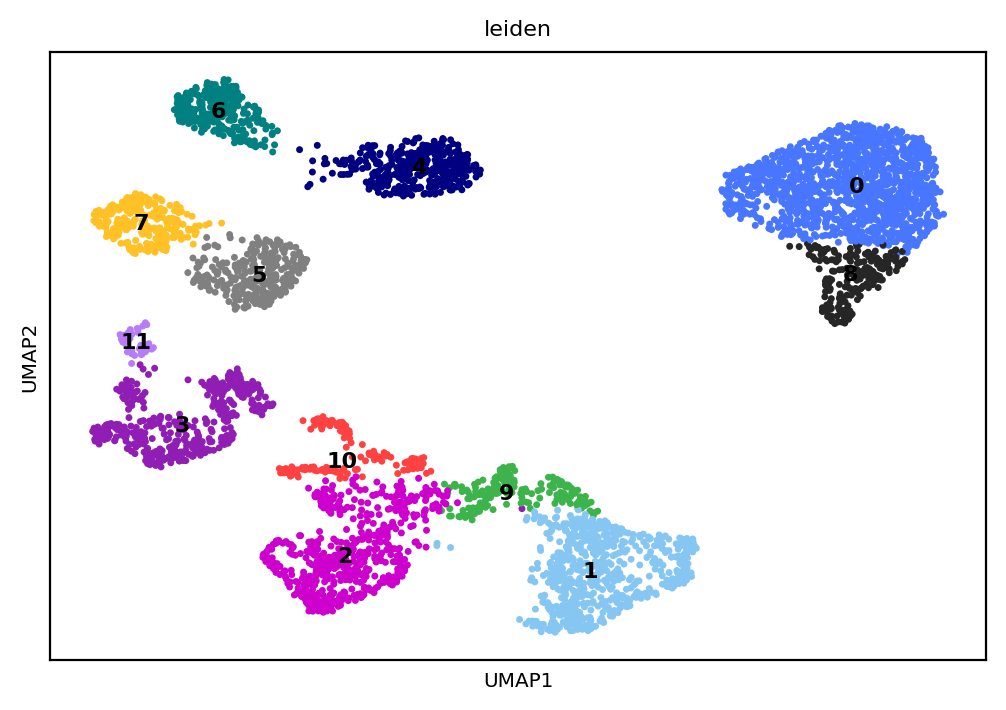

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')


### Filtering out a/b 1

this is needed for pseudo temporal applications as iPSC does not fit in dev trajectory
By removing iPSC it will provide:

cleaner pseudotime ordering along the specific developmental paths of interest

Better resolve the bifurcation mechanics between arterial and venous fates

Avoid trajectory distortions from the transcriptionally distinct iPSC state

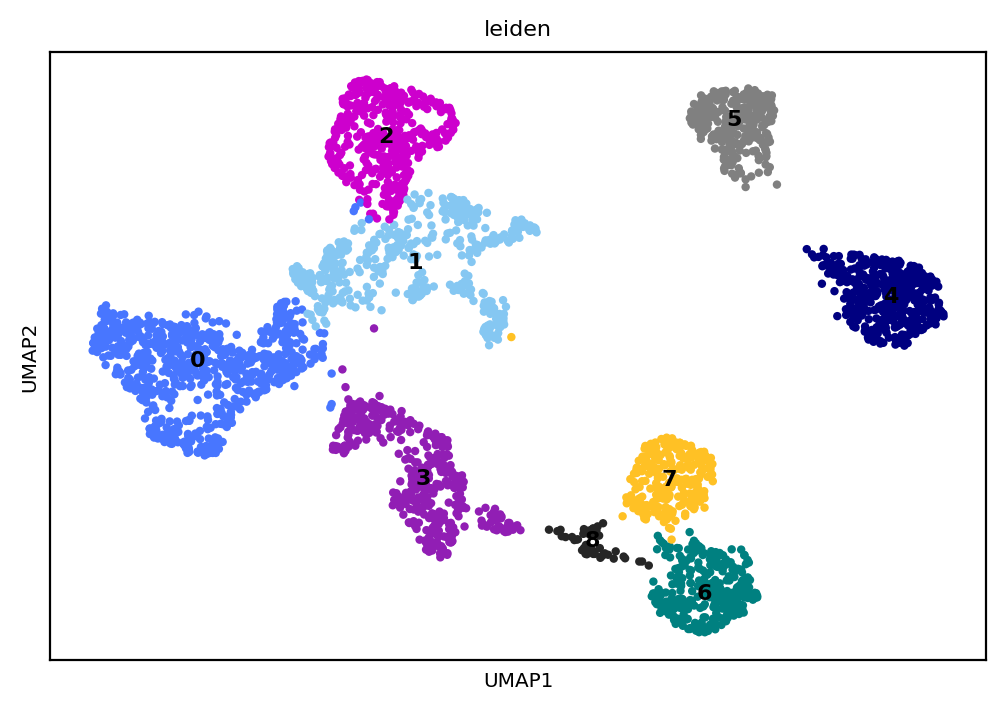

In [ ]:
sc.pl.umap(adata_filtered, color='leiden', legend_loc='on data')

In [ ]:
# 2. Re-compute UMAP (optional, but recommended for consistency)
sc.pp.neighbors(adata_filtered, n_pcs=30)#29 - 30
sc.tl.umap(adata_filtered)

sc.tl.leiden(adata_filtered, resolution = 0.15)#0.18 - 0.15
# 3. Update your pseudotemporal ordering start points
# Instead of iPSCs, use the LPM samples as starting points
start_clusters = ['LPM (WT)', 'LPM (HET1)']  # A2, B2 samples

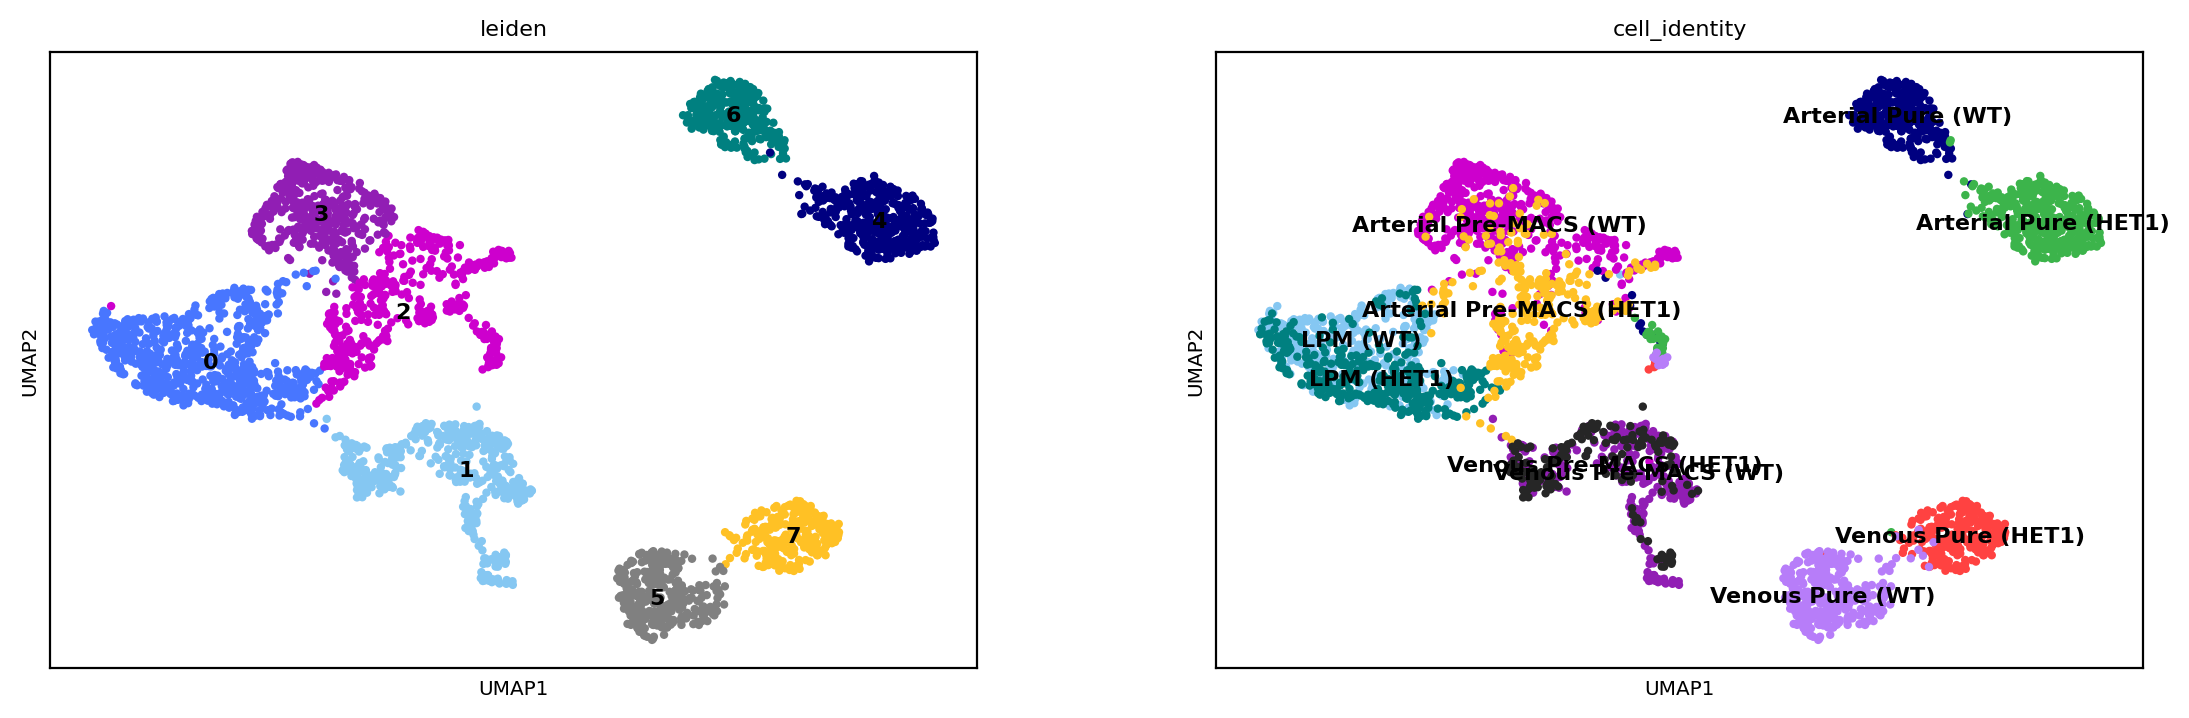

In [ ]:
sc.pl.umap(adata_filtered, color=['leiden','cell_identity'], legend_loc='on data')


This demonstrates the clustering to be hihgly succseful, howver there are several key groups that are not disasociated within samples:
Venous Pre-MACS(WT/HET1) are clustered tightly and thus form one cluster, similarly LPM (WT/HET1) are tightly clustered.

In [ ]:
leiden_to_celltype_filt = {
    '0': 'LPM',
    '1': 'Venous Pre-MACS',
    '2': 'Arterial Pre-MACS(HET1)',
    '3': 'Arterial Pre-MACS(WT)',
    '4': 'Arterial Pure (HET1)',
    '5': 'Venous Pure (WT)',
    '6': 'Arterial Pure (WT)',
    '7': 'Venous Pure (HET1)'    # Additional clusters...
}

In [ ]:
adata_filtered.obs['cluster_identity'] = adata_filtered.obs['leiden'].map(leiden_to_celltype_filt).astype('category')

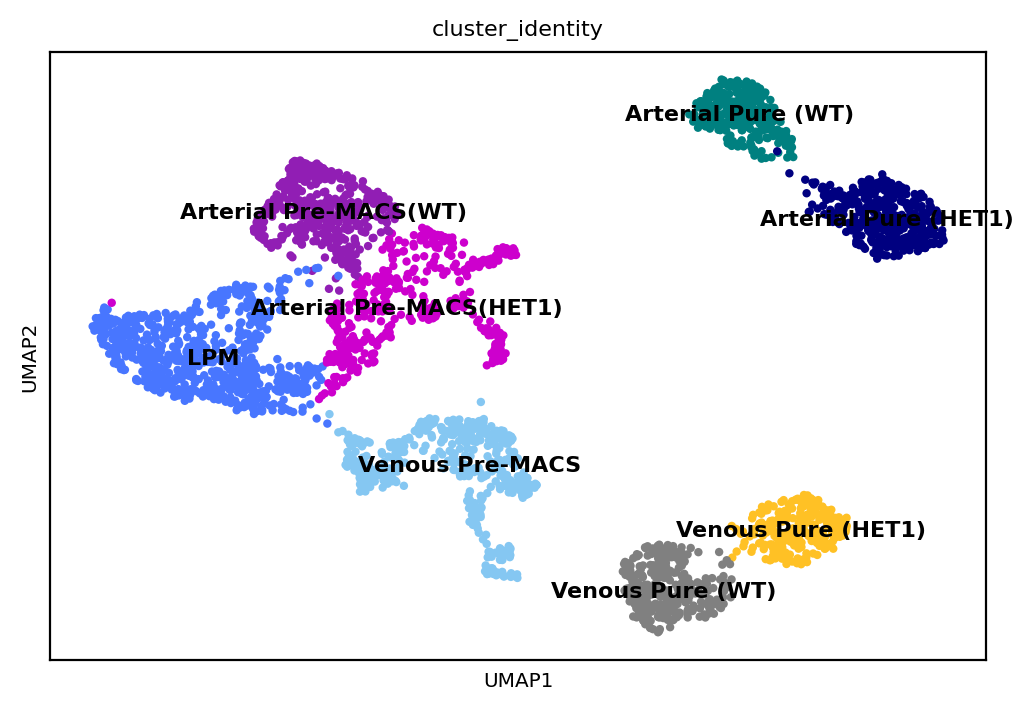

In [ ]:
sc.pl.umap(adata_filtered, color='cluster_identity', legend_loc='on data')


In [ ]:
# First, check for problematic object dtypes in your metadata
print("Object dtypes in obs:", adata_filtered.obs.select_dtypes(include=['object']).columns.tolist())
print("Object dtypes in var:", adata_filtered.var.select_dtypes(include=['object']).columns.tolist())

# Convert all object columns to categories or strings
for col in adata_filtered.obs.select_dtypes(include=['object']).columns:
    try:
        adata_filtered.obs[col] = adata_filtered.obs[col].astype('category')
    except:
        adata_filtered.obs[col] = adata_filtered.obs[col].astype(str)

for col in adata_filtered.var.select_dtypes(include=['object']).columns:
    try:
        adata_filtered.var[col] = adata_filtered.var[col].astype('category')
    except:
        adata_filtered.var[col] = adata_filtered.var[col].astype(str)


Object dtypes in obs: ['ntr']
Object dtypes in var: ['gene_id', 'ntr']


## Labelling leiden clusters

# write data out to run slingshot

In [ ]:
adata_filtered.write_h5ad('/content/drive/My Drive/Colab Notebooks/NSC3001/anndata_processed.h5ad')


### Using rpy2 to run slingshot

In [ ]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import numpy as np
import pandas as pd

In [ ]:
# Filter data
adata_filtered = adata[~adata.obs['sample'].isin(['sample_A1', 'sample_B1']), :].copy()

# Transfer filtered UMAP and identity data to R
umap_coords = pd.DataFrame(adata_filtered.obsm['X_umap'], index=adata_filtered.obs_names)
cell_identity = pd.Series(adata_filtered.obs['cell_identity'], index=adata_filtered.obs_names)

# Convert to R objects
r_umap = pandas2ri.py2rpy(umap_coords)
r_identity = pandas2ri.py2rpy(cell_identity)

# Set LPM samples as start clusters instead of iPSCs
start_clus = r.c('LPM (WT)', 'LPM (HET1)')
end_clus = r.c('Arterial Pure (WT)', 'Arterial Pure (HET1)',
               'Venous Pure (WT)', 'Venous Pure (HET1)')

